# 08_Simulate_Branchness_Metrics.ipynb

Simulate some fake data with (1) uniform spacing, (2) globs, and (3) branches/continuous spacing

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/Users/cchu/Desktop/phd_work/hyperChromatin/src/PoincareMaps')
import os
workdir = '../results/08'
os.makedirs(workdir, exist_ok=True)


3D cube

In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import torch 
from refs import celltype_colors
import matplotlib.pyplot as plt
from IPython.display import Image
from run_poincare_map import features_names

from main import *
from poincare_maps import *


In [107]:
def gen_uniform(size=100):
    x = np.random.uniform(0, 1, size=size).reshape(-1, 1)
    y = np.random.uniform(0, 1, size=size).reshape(-1, 1)
    z = np.random.uniform(0, 1, size=size).reshape(-1, 1)
    return np.concatenate([x, y, z], axis=1)

def gen_blobs(num_blobs=4, size=100, scale=0.1):
    # Calculate points per blob
    points_per_blob = size // num_blobs
    
    # Initialize array to store all points
    points = np.zeros((0, 3))
    centers = []
    for i in range(num_blobs):
        # Generate random center within unit cube
        center = np.random.uniform(0.2, 0.8, size=3)  # Avoiding edges
        centers.append(center)
        
        # Generate Gaussian distributed points around center
        blob = np.random.normal(loc=center, scale=scale, size=(points_per_blob, 3))
        
        # Clip values to keep within unit cube
        blob = np.clip(blob, 0, 1)
        
        # Add to points array
        points = np.vstack((points, blob))
    
    return points, centers


def gen_branches(branch_sample=50, **kwargs):
    # get blobs, pick one as the root
    # sample points along line between root and the other blobs
    points, centers = gen_blobs(**kwargs)

    root = centers[0]
    branch_points= np.zeros((0, 3))
    for i in range(1, len(centers)):
        leaf = centers[i]
        t = np.linspace(0, 1, branch_sample)  # 50 points along each branch
        branch = np.array([root + t_i * (leaf - root) for t_i in t])
        
        # Add some small random noise to make it more realistic
        noise = np.random.normal(0, 0.01, branch.shape)
        branch = branch + noise
        
        # Clip values to keep within unit cube
        branch = np.clip(branch, 0, 1)
        
        branch_points = np.vstack((branch_points, branch))

    # all_points = np.vstack([points] + branch_points)    
    return branch_points

    

def plot_3D_points(points):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:, 0], 
            points[:, 1], 
            points[:, 2],
            alpha=0.6)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    return fig, ax


In [116]:
uniform_points = gen_uniform(size=1000)
blob_points, _ = gen_blobs(scale=0.05, size=1000)
branch_points = gen_branches(branch_sample=100, scale=0.05, size=1000)

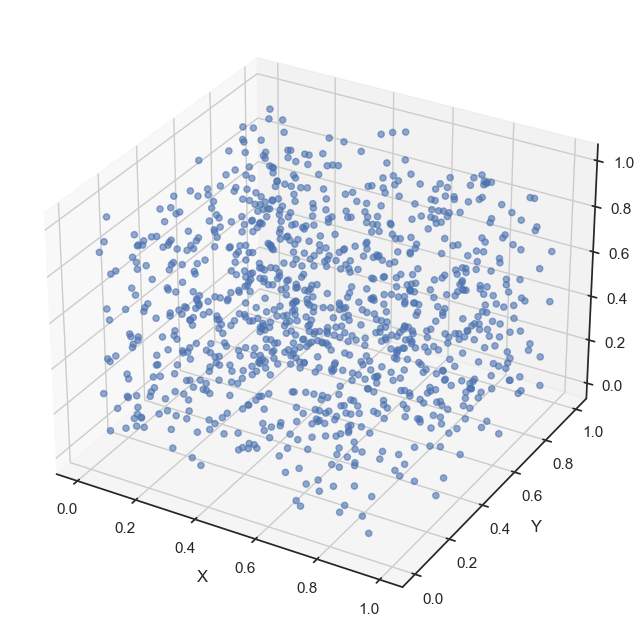

In [117]:
plot_3D_points(uniform_points)
plt.show()

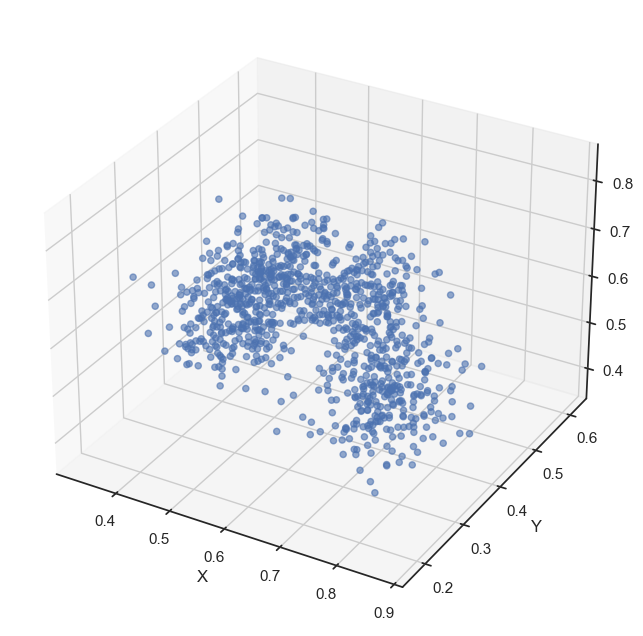

In [118]:
plot_3D_points(blob_points)
plt.show()

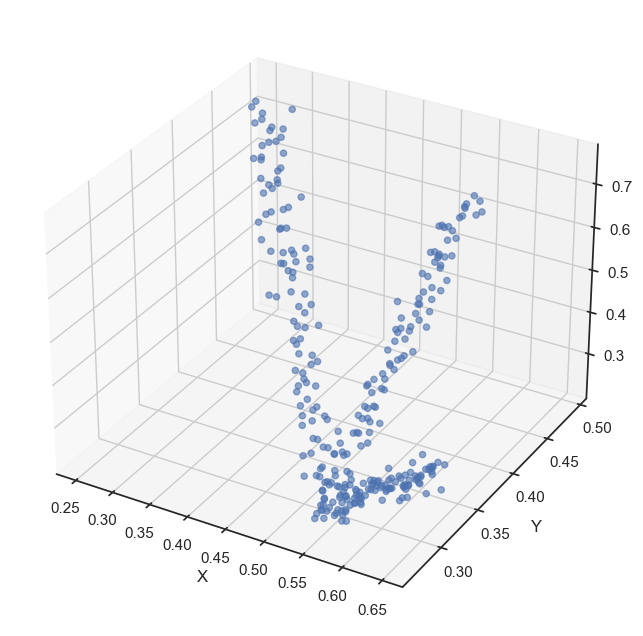

In [119]:
plot_3D_points(branch_points)
plt.show()

In [75]:
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
import numpy as np
from scipy.sparse.csgraph import minimum_spanning_tree

from networkx import from_scipy_sparse_array
from scipy.stats import skew
from sklearn.mixture import GaussianMixture

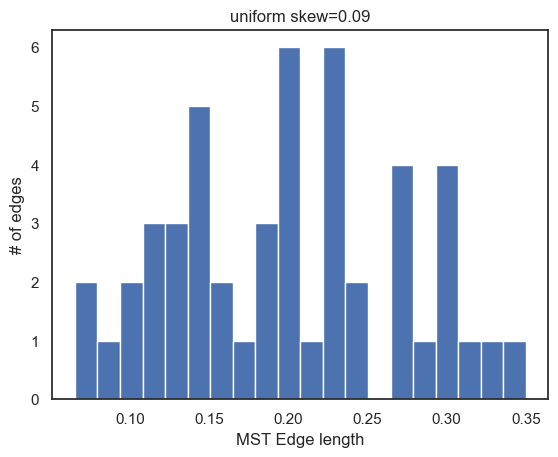

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


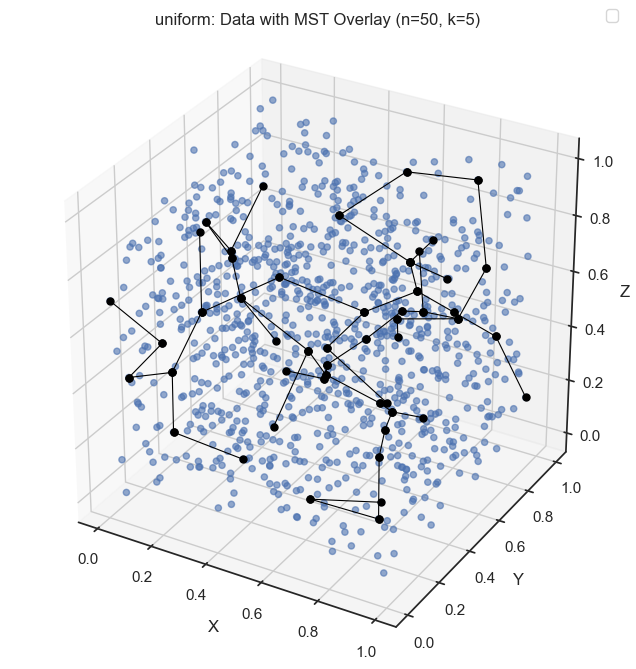

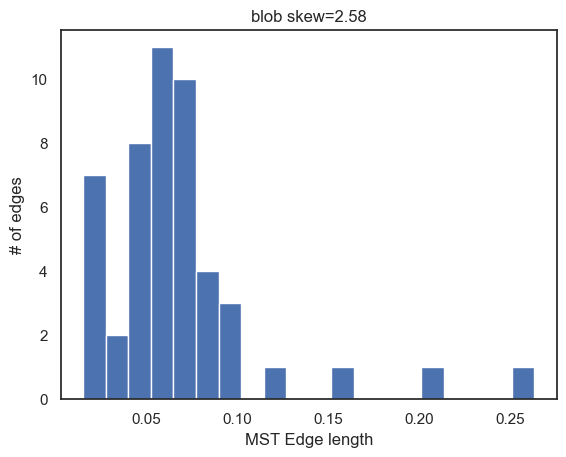

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


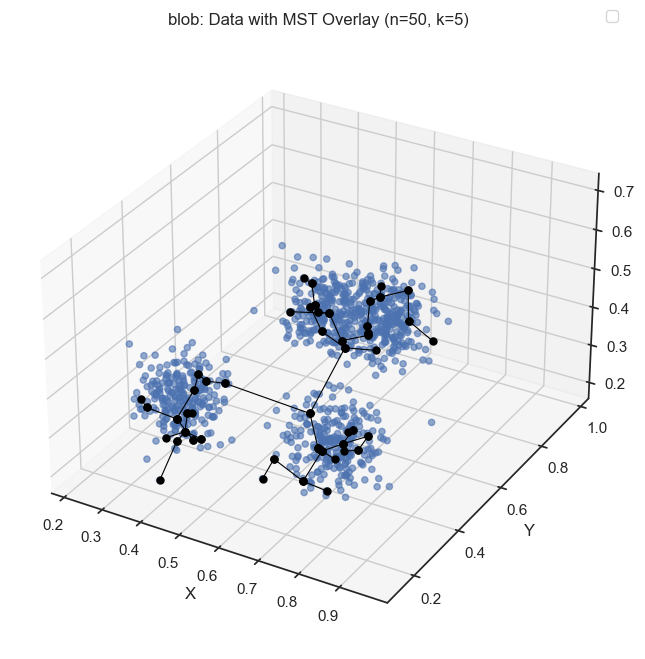

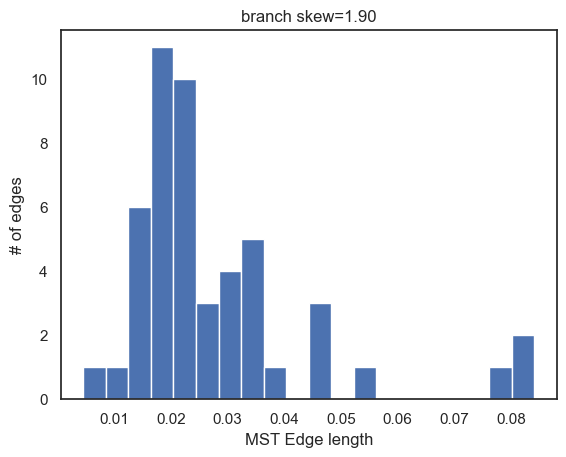

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


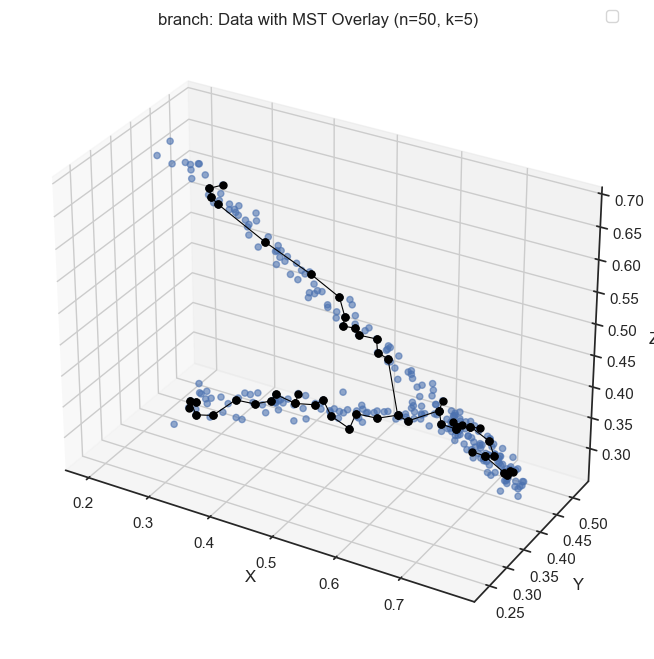

In [121]:

num_replicates = 10
sim_points = {
    "uniform": [gen_uniform(size=1000) for i in range(num_replicates)], 
    "blob": [gen_blobs(scale=0.05, size=1000)[0] for i in range(num_replicates)], 
    "branch": [gen_branches(branch_sample=100, scale=0.05, size=1000) for i in range(num_replicates)], 
}

branchiness_results = {}
branchlength_skewness = {name: [] for name in sim_points.keys()}
diff_median_and_max_results = {name: [] for name in sim_points.keys()}
var_results = {name: [] for name in sim_points.keys()}
# best_k_results = {name: [] for name in sim_points.keys()}
sample_size = 50
k = 5  # you can adjust this

num_samplings = 10
for name, points_list in sim_points.items():
    for points in points_list:
        df = pd.DataFrame(points)
    # 
        for i in range(num_samplings):

            sample_idx = np.random.choice(np.arange(df.shape[0]), size=sample_size, replace=False)
            X = df.iloc[sample_idx].values
            # Assume X is your N x D data matrix
            
            # nbrs = NearestNeighbors(n_neighbors=k, metric=lambda x, y: poin_dist(torch.tensor(x), torch.tensor(y)), algorithm='brute').fit(X)
            nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(X)
            distances, indices = nbrs.kneighbors(X)

            # Construct sparse adjacency matrix
            N = X.shape[0]
            row_indices = np.repeat(np.arange(N), k)
            col_indices = indices.flatten()
            edge_weights = distances.flatten()

            # get MST
            distances_matrix = pairwise_distances(X)
            complete_graph = csr_matrix(distances_matrix)

            mst_sparse = minimum_spanning_tree(complete_graph)
            G_mst = from_scipy_sparse_array(mst_sparse)

            mst_edge_lengths = []
            for u, v in G_mst.edges():
                edge_length = distances_matrix[u, v]
                mst_edge_lengths.append(edge_length)

            skewness = skew(mst_edge_lengths)
            diff_median_and_max = np.max(mst_edge_lengths) - np.median(mst_edge_lengths)
            var = np.var(mst_edge_lengths)

            branchlength_skewness[name].append(skewness)
            diff_median_and_max_results[name].append(diff_median_and_max)
            var_results[name].append(var)


    plt.hist(mst_edge_lengths, bins=20) # skip self
    plt.xlabel('MST Edge length')
    plt.ylabel('# of edges')
    plt.title(f'{name} skew={skewness:.2f}')
    plt.show()

    # knn_graph = csr_matrix((edge_weights, (row_indices, col_indices)), shape=(N, N))
    # # Make it symmetric (undirected)
    # knn_graph = knn_graph.maximum(knn_graph.T)

    # mst_sparse = minimum_spanning_tree(knn_graph)
    # G_mst = from_scipy_sparse_array(mst_sparse)
    

    # # Optionally analyze node degrees
    # degree_dict = dict(G_mst.degree())
    # branch_nodes = [n for n, d in degree_dict.items() if d >= 3]
    # branchiness = len(branch_nodes) / len(G_mst.nodes)
    # branchiness_results[feature_name] = branchiness

    # Plot points
    # fig, ax = plt.subplots()
    fig, ax = plot_3D_points(points)

    # Overlay MST edges
    for u, v in G_mst.edges():
        x_coords = [X[u, 0], X[v, 0]]
        y_coords = [X[u, 1], X[v, 1]]
        z_coords = [X[u, 2], X[v, 2]]

        # zoom1_coordinates = np.array(linear_scale(np.array([x_coords, y_coords]).T))
        plt.plot(x_coords, y_coords, z_coords, color='black', linewidth=0.8, marker='o', markersize=5)

    plt.title(f"{name}: Data with MST Overlay (n={sample_size}, k={k})")
    # plt.axis('off')
    ax.set_aspect('equal')
    plt.legend(bbox_to_anchor=(1, 1.05))
    plt.show()


In [126]:
branchlength_skewness_df = pd.DataFrame(branchlength_skewness).stack().reset_index().rename(columns={'level_1': 'method', 0: 'Branch length skewness'})
diff_median_and_max_results_df = pd.DataFrame(diff_median_and_max_results).stack().reset_index().rename(columns={'level_1': 'method', 0: 'max - median'})
var_results_df = pd.DataFrame(var_results).stack().reset_index().rename(columns={'level_1': 'method', 0: 'var'})
display(branchlength_skewness_df.head())
display(diff_median_and_max_results_df.head())
display(var_results_df.head())


,level_0,method,Branch length skewness
0,0,uniform,-0.079957
1,0,blob,1.446218
2,0,branch,2.066975
3,1,uniform,0.311771
4,1,blob,1.655670


,level_0,method,max - median
0,0,uniform,0.160839
1,0,blob,0.135633
2,0,branch,0.134357
3,1,uniform,0.200447
4,1,blob,0.143235


,level_0,method,var
0,0,uniform,0.005120
1,0,blob,0.001045
2,0,branch,0.001165
3,1,uniform,0.005622
4,1,blob,0.001420


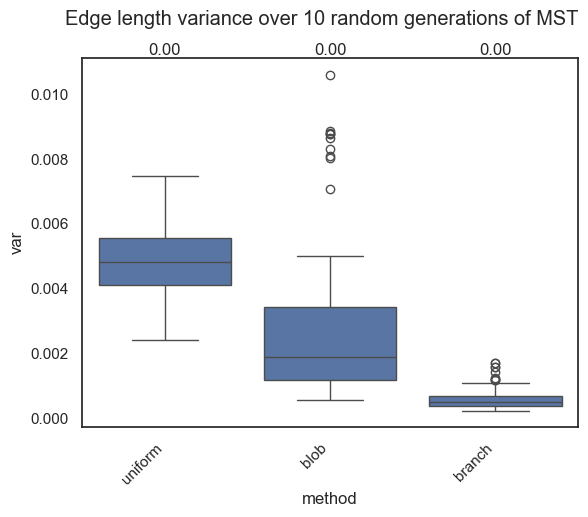

In [132]:
ax = sns.boxplot(
    var_results_df, x='method', y='var', 
    order=['uniform', 'blob', 'branch'],
)

for i, method in enumerate(['uniform', 'blob', 'branch']):
    median = var_results_df[var_results_df['method'] == method]['var'].median()
    ax.text(i, ax.get_ylim()[1], f'{median:.2f}', 
            horizontalalignment='center', verticalalignment='bottom')

plt.xticks(rotation=45, ha='right')
plt.suptitle("Edge length variance over 10 random generations of MST")
plt.show()

In [136]:
branchlength_skewness_df.groupby('method').size()

method
blob       100
branch     100
uniform    100
dtype: int64

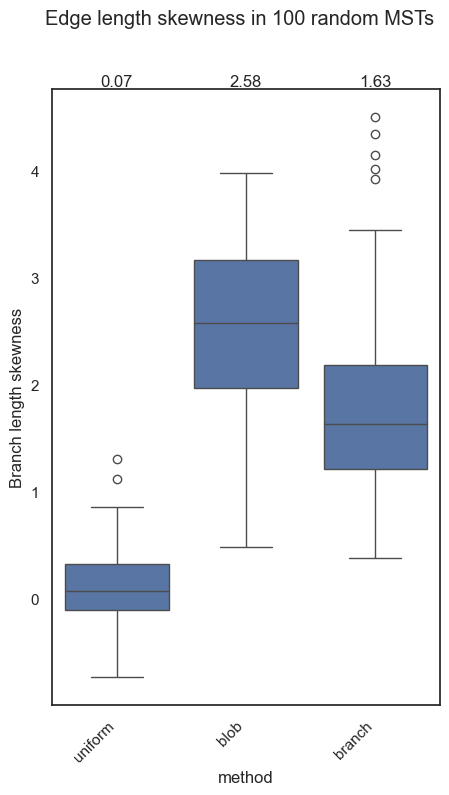

In [137]:
fig, ax = plt.subplots(figsize=(5, 8))
ax = sns.boxplot(
    branchlength_skewness_df, x='method', y='Branch length skewness', 
    order=['uniform', 'blob', 'branch'], ax=ax
)

for i, method in enumerate(['uniform', 'blob', 'branch']):
    median = branchlength_skewness_df[branchlength_skewness_df['method'] == method]['Branch length skewness'].median()
    ax.text(i, ax.get_ylim()[1], f'{median:.2f}', 
            horizontalalignment='center', verticalalignment='bottom')

plt.xticks(rotation=45, ha='right')
plt.suptitle("Edge length skewness in 100 random MSTs")
plt.show()

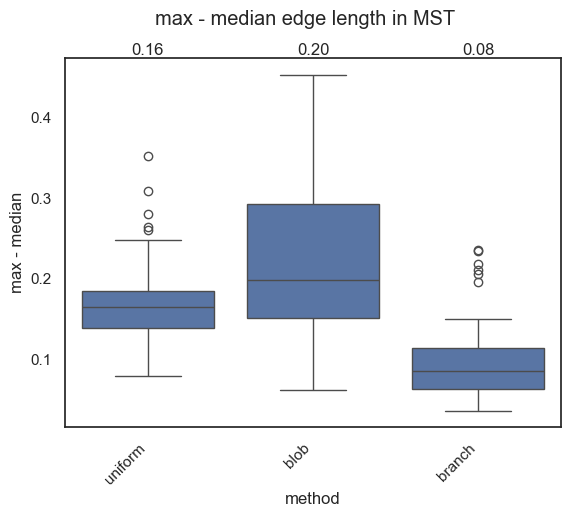

In [130]:
ax = sns.boxplot(
    diff_median_and_max_results_df, x='method', y='max - median', 
    order=['uniform', 'blob', 'branch'],
)

for i, method in enumerate(['uniform', 'blob', 'branch']):
    median = diff_median_and_max_results_df[diff_median_and_max_results_df['method'] == method]['max - median'].median()
    ax.text(i, ax.get_ylim()[1], f'{median:.2f}', 
            horizontalalignment='center', verticalalignment='bottom')

plt.xticks(rotation=45, ha='right')
plt.suptitle("max - median edge length in MST")
plt.show()